In [1]:
#text clustering
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/My Drive/result.csv')
df.head()

,_id,topic,heading,summary,date_published,content,tags
0,5ef0d2b4d83b3587cb500ec9,"[""analysis""]","[""Don’t discriminate against non-resident migr...","[""Create a legal regime that allows them to ac...","[""Updated: Jun 22, 2020 19:30 IST""]","[""Prime Minister (PM) Narendra Modi recently a...","[""India"",""Narendra Modi"",""BIHAR"",""Haryana"",""Mi..."
1,5ef0d2b6d83b3587cb500eca,NaN,"[""‘Sino-India ties will deteriorate further’: ...","[""Other Videos""]",NaN,NaN,NaN
2,5ef0d2b8d83b3587cb500ecb,"[""opinion""]","[""India has closed military gap with China alo...","[""Over the past dozen years India has not only...","[""Updated: Jun 22, 2020 16:01 IST""]","[""India has the "","", says a recent Harvard Uni...","[""Indian Army"",""Galwan Valley"",""India China bo..."
3,5ef0d2bad83b3587cb500ecc,"[""opinion""]","[""Ladakh faceoff: Looking back for a way forwa...","[""DRAW THE LINE Policing the borders and preve...","[""Updated: Jun 22, 2020 18:06 IST""]","[""On December 11, 1917, General Edmund Allenby...",NaN
4,5ef0d2bdd83b3587cb500ecd,"[""editorials""]","[""Redesign the model village scheme | HT Edito...","[""For MPs to take it up, expand its ambit to a...","[""Updated: Jun 22, 2020 18:56 IST""]","[""A study commissioned by the Union ministry o...",NaN


In [4]:
df.heading[1]

'["‘Sino-India ties will deteriorate further’: Ex-envoy to China on Galwan faceoff\xa0 \xa0"]'

In [9]:
import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import re

In [7]:
# data preprocessing
stemmer = SnowballStemmer(language='english',ignore_stopwords=True)
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [10]:
# preview after preprocessing
doc_sample = df.heading[1]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['["‘Sino-India', 'ties', 'will', 'deteriorate', 'further’:', 'Ex-envoy', 'to', 'China', 'on', 'Galwan', 'faceoff\xa0', '\xa0"]']


 tokenized and lemmatized document: 
['sino', 'india', 'tie', 'deterior', 'envoy', 'china', 'galwan', 'faceoff']


In [17]:
# Preprocess the headline text, saving the results as ‘processed_docs’
processed_docs = df['heading'].map(preprocess)
#processed_docs.head(5)
df['processed_heading'] = processed_docs
#df.head()
df['processed_heading'] = df['processed_heading'].apply(lambda x: ' '.join(x))

df['processed_heading'][0]

'discrimin resid migrant opinion'

In [18]:
#feature extraction
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.processed_heading.values)
features = vec.transform(df.processed_heading.values)

In [20]:
#model training
random_state = 0
cls = MiniBatchKMeans(n_clusters=5, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

In [21]:
#predict on new data
cls.predict(features)

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 4, 0, 1, 0, 0, 0, 1, 0, 4, 1, 0, 4, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 3, 0, 0, 0, 0, 4, 4, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 4, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 4, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1], dtype=int32)

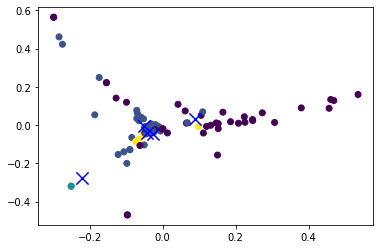

In [22]:
#visualization
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [26]:
#evaluation with labelled dataset
from sklearn.metrics import homogeneity_score
homogeneity_score(df.heading, cls.predict(features))

0.21296272186763776

In [24]:

#evaluation with unlabelled dataset
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

0.020007920235676806

In [27]:
#topic modelling
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

random_state = 0

def only_nouns(texts):
    output = []
    for doc in nlp.pipe(texts):
        noun_text = " ".join(token.lemma_ for token in doc if token.pos_ == 'NOUN')
        output.append(noun_text)
    return output


df['noun_heading'] = only_nouns(df['heading'])

df.head()

,_id,topic,heading,summary,date_published,content,tags,processed_heading,noun_heading
0,5ef0d2b4d83b3587cb500ec9,"[""analysis""]","[""Don’t discriminate against non-resident migr...","[""Create a legal regime that allows them to ac...","[""Updated: Jun 22, 2020 19:30 IST""]","[""Prime Minister (PM) Narendra Modi recently a...","[""India"",""Narendra Modi"",""BIHAR"",""Haryana"",""Mi...",discrimin resid migrant opinion,migrant
1,5ef0d2b6d83b3587cb500eca,NaN,"[""‘Sino-India ties will deteriorate further’: ...","[""Other Videos""]",NaN,NaN,NaN,sino india tie deterior envoy china galwan fac...,tie ex envoy faceoff
2,5ef0d2b8d83b3587cb500ecb,"[""opinion""]","[""India has closed military gap with China alo...","[""Over the past dozen years India has not only...","[""Updated: Jun 22, 2020 16:01 IST""]","[""India has the "","", says a recent Harvard Uni...","[""Indian Army"",""Galwan Valley"",""India China bo...",india close militari china border,gap border
3,5ef0d2bad83b3587cb500ecc,"[""opinion""]","[""Ladakh faceoff: Looking back for a way forwa...","[""DRAW THE LINE Policing the borders and preve...","[""Updated: Jun 22, 2020 18:06 IST""]","[""On December 11, 1917, General Edmund Allenby...",NaN,ladakh faceoff look forward,faceoff way
4,5ef0d2bdd83b3587cb500ecd,"[""editorials""]","[""Redesign the model village scheme | HT Edito...","[""For MPs to take it up, expand its ambit to a...","[""Updated: Jun 22, 2020 18:56 IST""]","[""A study commissioned by the Union ministry o...",NaN,redesign model villag scheme editori,model village scheme editorial


In [28]:
# change this to see different results using the components_ attribute
n_topics = 5

#for extracting features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer(max_features=5000, stop_words="english", max_df=0.95, min_df=2)
features = vec.fit_transform(df.noun_heading)

#for topic modelling

from sklearn.decomposition import NMF
cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [29]:
# list of unique words found by the vectorizer
feature_names = vec.get_feature_names()

# number of most influencing words to display per topic
n_top_words = 15

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    # topic_vec.argsort() produces a new array
    # in which word_index with the least score is the
    # first array element and word_index with highest
    # score is the last array element. Then using a
    # fancy indexing [-1: -n_top_words-1:-1], we are
    # slicing the array from its end in such a way that
    # top `n_top_words` word_index with highest scores
    # are returned in desceding order
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(feature_names[fid], end=' ')
    print()

0 case tally record death doggo medium nepotism woman faceoff ex editorial economy discourse debate date 
1 coach head test team app revenge economy people hold job centre discourse debate border plan 
2 photo woman respect autonomy wife ex situation support faceoff people debate hold man cop norm 
3 time class date app revenge economy woman respect autonomy wife ex faceoff situation video hold 
4 lockdown school fee woman respect autonomy wife ex faceoff hold plan action editorial stage return 


In [30]:
# to identify topic of a new document
new_articles = [
    "Playstation network was down so many people were angry",
    "Germany scored 7 goals against Brazil in worldcup semi-finals"
]
# first transform the text into features using vec
# then pass it to transform of cls
# the result will be a matrix of shape [2, 10]
# then we sort the topic id based on the score using argsort
# and take the last one (with the highest score) for each row using `[:,-1]` indexing
cls.transform(vec.transform(new_articles)).argsort(axis=1)[:,-1]

array([3, 4])